## Stochastic volatility model for option pricing using the Log Ornstein-Uhlenbeck model


Consider a special case of the Log Ornstein-Uhlenbeck model, where the underlying asset $S_t$ satisfies the stochastic differential equation

$$dS_t=rS_tdt+e^{Y_t}S_tdW_t,$$ $$dY_t=(-\alpha(2+Y_t)+0.4\sqrt{\alpha}\sqrt{1-\rho^2})dt+0.4\sqrt{\alpha}dZ_t,$$ $$dZ_t=\rho dW_t+\sqrt{1-\rho^2}dB_t.$$
Here, $W_t$ and $B_t$ are two independent Brownian motions and $e^{Y_t}$ is the stochastic volatility.

We want to estimate the European call option price  

$$e^{-rT}\mathbb{E}[\text{max}(S_T-K,0)]$$

where $e^{-rT}$ is the discount factor, $K$ is the strike price, and $T$ is the time at maturity of the option. In order to obtain $S_T$, we will perform a forward Euler discretization of the SDE system and simulate to maturity of the option.

Using the time discretization $t_n=n\Delta t,\hspace{1mm} n=1,2..N$ where $\Delta t=\frac{T}{N}$, the problem discretizes to

$$S_{n+1}-S_n=rS_n\Delta t+e^{Y_n}S_n(W_{n+1}-W_n),$$
$$Y_{n+1}-Y_n=(-\alpha(2+Y_n)+0.4\sqrt{\alpha}\sqrt{1-\rho^2})\Delta t+0.4\sqrt{\alpha}(Z_{n+1}-Z_n),$$ $$Z_{n+1}-Z_n=\rho (W_{n+1}-W_n)+\sqrt{1-\rho^2}(B_{n+1}-B_n),$$

where $W_{n+1}-W_n,$ and $B_{n+1}-B_n$ are $N(0,\Delta t)$ distributed. We will consider an at the money call option with parameters $\alpha=100, \rho=-0.3, r=0.04, T=0.75, Y_0=-1$ and $S_0=K=100$.

In [382]:
"""Libraries we will use."""

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [253]:
"""Some global variables."""

T=0.75
alpha=100
rho=-0.3
r=0.04
Y_0=-1
S_0=100
K=100

In [600]:
"""This function discretizes the system of SDE's and solves for S_t on the given time interval using forward Euler."""

def LogOU_forward_euler(N,M):      # N is the number of timesteps, hence it determines the timestep dt=T/N.
                                   # M is the number of simulations.
    
    """Creating matrices for the stochastic processes,
    and initializing Y_0 and S_0."""
    
    #sp.random.seed(10)
    dt=T/N
    Y=np.zeros((M,N))
    S=np.zeros((M,N))
    Y[:,0]=Y_0*np.ones(M)
    S[:,0]=S_0*np.ones(M)
    
    """Forward Euler steps. Drawing M*(N-1) values from a N(0,dt) distribution, one
    for each simulation and timestep. """
    
    dW=np.random.normal(0, np.sqrt(dt), size=(M,N-1))   
    dB=np.random.normal(0, np.sqrt(dt), size=(M,N-1))
    dZ=rho*dW+np.sqrt(1-rho**2)*dB
    for i in range(N-1):
        Y[:,i+1]=Y[:,i]+(-alpha*(2+Y[:,i])+0.4*np.sqrt(alpha)*np.sqrt(1-rho**2))*dt+0.4*np.sqrt(alpha)*dZ[:,i]
        S[:,i+1]=S[:,i]+r*S[:,i]*dt+np.exp(Y[:,i])*S[:,i]*dW[:,i]

    return S

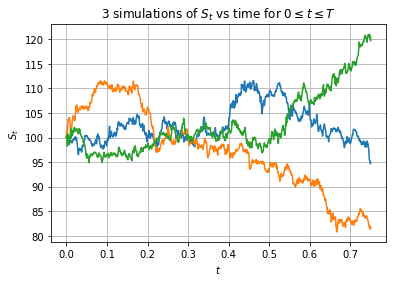

In [741]:
"""Some plotting of S_t."""

N=1000
M=3
t=np.linspace(0,T,N)
S=LogOU_forward_euler(N,M)
plt.plot(t,S.T)
plt.title(str(M)+" simulations of $S_t$ vs time for $0\leq t\leq T$")
plt.ylabel("$S_t$")
plt.xlabel("$t$")
plt.grid(True)


Now, we use the Monte Carlo estimate of the expectation. This estimate approaches the true expectation as we increase the number of simulations $M$ in accordance with the law of large numbers. We have
$$e^{-rT}\mathbb{E}[\text{max}(S_T-K,0)\approx \frac{1}{M}\sum_{j=1}^Me^{-rT}\text{max}(S^k_T-K,0)$$ 
where $S^k_T, k=1,2..M$ are samples of $S_T$ using the forward Euler discretization.

In [742]:
"""The expression for C below is a vector containing M samples of exp(-rT)max(S^k_T-K,0). 
We calculate the mean of C to obtain an estimate of the true option price. 
It is important to let M be large in order to ensure convergence."""


import time
start_time = time.time()
N=1000
M=10**4
S=LogOU_forward_euler(N,M)                                      
print("--- %s seconds ---" % (time.time() - start_time))
C=np.exp(-r*T)*np.maximum(S[:,-1]-K*np.ones(M),np.zeros(M)) 
C_mean=np.mean(C)
C_variance=np.std(C)**2
C_se=np.std(C)/np.sqrt(M)

print("Call option price:{0}, Variance:{1} Standard error:{2}".format(C_mean, C_variance, C_se))

--- 1.7299838066101074 seconds ---
Call option price:7.069831824519987, Variance:91.38525806036311 Standard error:0.09559563696129814


## Calculating call option price and standard deviation using the antithetic variance reducing method:
With this method, we can use a lower $M$ for the same standard error, resulting in a lower computation time 

In [736]:
"""This function discretizes the system of SDE's and solves for S_t on the given time interval using forward Euler.
The antithetic variance reduction method is implemented here."""

def LogOU_forward_euler_antithetic(N,M):      # N is the number of timesteps, hence it determines the timestep dt=T/N.
                                              # M is the number of simulations.
    
    """Creating matrices for the stochastic processes,
    and initializing Y_0 and S_0."""
    
    
    #sp.random.seed(10)
    dt=T/N
    Y=np.zeros((2*M,N))
    S=np.zeros((2*M,N))
    Y[:,0]=Y_0*np.ones(2*M)
    S[:,0]=S_0*np.ones(2*M)
    
    """Forward Euler steps. Drawing M*(N-1) values from a N(0,dt) distribution, one
    for each simulation and timestep. """
    
    dW=np.random.normal(0, np.sqrt(dt), size=(M,N-1))   
    dW=np.vstack((dW,-dW))                             # Antithetic variables method for variance reduction
    dB=np.random.normal(0, np.sqrt(dt), size=(M,N-1))
    dB=np.vstack((dB,-dB))
    dZ=rho*dW+np.sqrt(1-rho**2)*dB
    for i in range(N-1):
        Y[:,i+1]=Y[:,i]+(-alpha*(2+Y[:,i])+0.4*np.sqrt(alpha)*np.sqrt(1-rho**2))*dt+0.4*np.sqrt(alpha)*dZ[:,i]
        S[:,i+1]=S[:,i]+r*S[:,i]*dt+np.exp(Y[:,i])*S[:,i]*dW[:,i]

    return S

In [731]:
"""The expression for C below is a vector containing M samples of exp(-rT)max(S^k_T-K,0). 
We calculate the mean of C to obtain an estimate of the true option price. 
It is important to let M be large in order to ensure convergence."""
import time

N=1000
M=450*10
start_time = time.time()
S=LogOU_forward_euler_antithetic(N,M)
print("--- %s seconds ---" % (time.time() - start_time))
C=np.exp(-r*T)*0.5*(np.maximum(S[0:M,-1]-K,0)+np.maximum(S[M:2*M,-1]-K,0))
C_mean=np.mean(C)
C_variance=np.std(C)**2
C_se=np.std(C)/np.sqrt(M)
print("Call option price:{0}, Variance:{1} Standard error:{2}".format(C_mean, C_variance, C_se))

--- 1.1554453372955322 seconds ---
Call option price:6.904828053176137, Variance:21.538940019190836 Standard error:0.06918403801004783
